Dnes se podíváme na nejjednodušší modely neuoronových sítí, které jsme si ukazovali na přednášce - na perceptron a vícevrstvý perceptron. 

# Perceptron

Implementace perceptronového algoritmu je jednoduchá - parametry perceptronu jsou jen jeden vektor a adaptační pravidlo je také snadné. Implementaci uděláme jako třídu, která má interface inspirovaný populární knihovnou scikit-learn, tj. parametry se nastaví v konstruktoru a třída potom má dvě metody - `fit(X, y)` a `predict(X)`.

V metodách využíváme maticového zápisu - vážený součet píšeme jako skalární součin. To v kombinaci s použitím knihovny `numpy` výrazně zjednodušuje implementaci a navíc je algoritmus rychlejší.

In [1]:
import numpy as np

class Perceptron:
    
    def __init__(self, lr, max_iter=100):
        self.lr = lr
        self.max_iter = max_iter
        
    def fit(self, train_X, train_y):
        train_x = np.array(train_X)
        train_x = self._add_ones(train_x)
        self.w_ = np.zeros(train_x.shape[1])
        
        for _ in range(self.max_iter):
            for x,y in zip(train_x, train_y):
                y_hat = (np.sign(np.dot(x, self.w_.T)) + 1)/2 # tady nemuzeme pouzit predict, pridala by znovu 1
                self.w_ = self.w_ + self.lr*(y - y_hat)*x
        
    def predict(self, X):
        x = np.array(X)
        x = self._add_ones(x)
        return (np.sign(np.dot(x, self.w_.T)) + 1)/2 # signum je -1 nebo 1 -> prevedeme na 0 nebo 1
    
    def _add_ones(self, x): # pridame sloupecek jednicek misto biasu
        ones = np.ones(shape=(x.shape[0],1))
        x = np.append(ones,x, axis=1)        
        return x

Pro otestování si vygenerujeme data. Použijeme generátory jednoduchých dat z knihovny scikit-learn. A vytvoříme data se dvěma třídami. Všimněte si rozdílných výsledků pokud jsou třídy separabilní a pokud ne.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

# jednoducha metoda na zobrazeni rozhodovaci hranice, pozdeji budeme funkci pouzivat i pro one-hot encoding
def draw_boundary(model, X, y, one_hot=False):
    
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    if one_hot:
        Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(12,8))
    plt.scatter(X[:,0], X[:,1], c=y)
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.show()

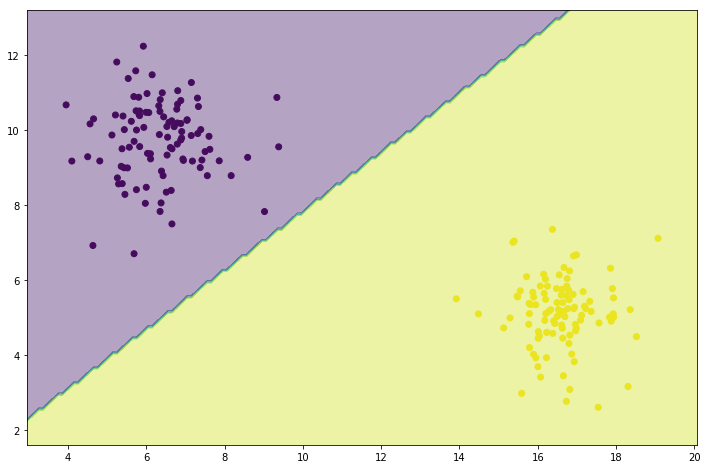

In [3]:
from sklearn import datasets

X, y = datasets.make_blobs(centers=2, n_samples=200)

X += (10,10)

perc = Perceptron(0.1, 1000)
perc.fit(X, y)
draw_boundary(perc, X, y)

# Vícevrstvý perceptron

Implementace vícevrstvé neuronové sítě je podobně jednoduchá jako u perceptronu, jen je potřeba si zopakovat, jakým způsobem vypadají adaptační pravidla. Použijeme opět maticový zápis.



In [4]:
class MLP:
    
    def __init__(self, layer_sizes, alpha=0.1):
        self.layer_sizes = layer_sizes
        self.layers = []
        self.alpha = alpha
        
        for (p, n) in zip(self.layer_sizes, self.layer_sizes[1:]):
            self.layers.append(np.random.normal(size=(p+1, n)))
        
    def predict(self, X):
        activations = np.array(X)
        try:
            for layer in self.layers:
                activations_1 = self._add_ones(activations) # pridame 1 pro bias
                activations = 1/(1+np.exp(np.dot(activations_1, layer)))
        except Exception as e:
            print("Activations:", activations)
            raise e

        return activations
    
    def fit(self, X, y):
        pass
        # zkuste dopsat sami :)
        
    def _add_ones(self, x): # pridame sloupecek jednicek misto biasu
        ones = np.ones(shape=(x.shape[0],1))
        x = np.append(ones,x, axis=1)        
        return x

In [5]:
mlp = MLP([3,5,2])

mlp.predict(np.array([[1,2,3], [1,2,7]]))

array([[0.22455239, 0.20501284],
       [0.26833379, 0.19667912]])

# Stručný úvod do tensorflow

Pro implementaci neuronových sítí se dnes používají moderní knihovny jako např. tensorflow. Dnes si jen ukážeme, jak použít tzv. keras interface pro vytvoření a natrénování jednoduché dopředné sítě.

In [6]:
# napred si pripravime data 

x, y = datasets.make_blobs(n_samples=300, centers=3)

x_train, x_test = x[:250], x[250:]
y_train, y_test = y[:250], y[250:]

import tensorflow as tf

# nastavime architekture site
model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation=tf.nn.sigmoid),
    tf.keras.layers.Dense(3, activation=tf.nn.softmax)
    ]
)

# nastavime optimalizaci
model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# natrenujeme sit
model.fit(x_train, y_train, epochs=200, verbose=0)
# a udelame predpovedi na par instancich
model.predict(x_test[:10])

C:\Users\marti\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


array([[0.6768614 , 0.09737093, 0.22576767],
       [0.16211085, 0.07971676, 0.7581724 ],
       [0.02420384, 0.9410352 , 0.03476093],
       [0.02491761, 0.92752564, 0.04755669],
       [0.02015057, 0.9291274 , 0.0507221 ],
       [0.6791824 , 0.09639697, 0.2244206 ],
       [0.15844703, 0.06820055, 0.77335244],
       [0.02667369, 0.9012815 , 0.07204488],
       [0.67691433, 0.09690875, 0.22617689],
       [0.68077546, 0.09658297, 0.22264154]], dtype=float32)

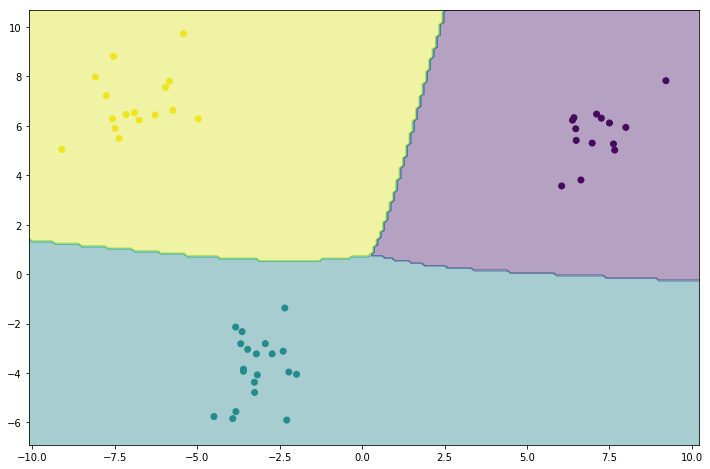

In [7]:
draw_boundary(model, x_test, y_test, one_hot=True)

Většinou budete nejpíš používat tensorflow na podobné úrovni jako výše, tj. budete vytvářet modely z existujících modulů. Podívejme se ale rychle trochu hlouběji na to, jak tensorflow funguje.

Tensorflow je ve skutečnosti knihovna pro symbolické počítání. Můžeme v ní definovat výpočet (výraz), který později vyhodnotíme. Z hlediska neuronových sítí je důležité, že tensorflow z tohoto výrazu také umí spočítat gradient a navíc obsahuje řadu optimalizátorů.

V tensorflow jsou tři hlavní typy "proměnných" - placeholder se používá pro vstupy do výrazu (když ho potom chceme vyhodnotit, musíme jim dát hodnotu), Constant se používá pro konstanty a Variable se používá pro proměnné, které se případně dají trénovat. Příklad vytvoření jednoduchého výrazu který spočítá lineární model typu $b + \sum_{i=1}^3 w_i x_i$ je níže. Všímněte si, že x je placeholder a hodnotu dostane až později. Kromě toho počítáme i MSE na základě y, máme tedy připravený model pro lineární regresi, který se může učit předpovídat y na základě x.

In [8]:
import pprint
# vytvorime si trenovaci data a zobrazime je
x_train = np.random.uniform(0, 1, size=(100, 3))
y_train = np.dot(x_train, np.array([2,3,1])) + 1
pprint.pprint(list(zip(x_train, y_train))[:10])

[(array([0.81099553, 0.16301654, 0.74347595]), 3.8545166183509414),
 (array([0.61034913, 0.22761193, 0.79891722]), 3.702451274388427),
 (array([0.11466772, 0.18053499, 0.78395035]), 2.5548907635554),
 (array([0.60923959, 0.36720874, 0.5335667 ]), 3.8536720985827992),
 (array([0.31890134, 0.35695557, 0.55063483]), 3.259304218429664),
 (array([0.90845107, 0.88950449, 0.52764287]), 6.013058493226856),
 (array([0.08540516, 0.38349846, 0.70690234]), 3.0282080529031323),
 (array([0.98236142, 0.54576439, 0.98570232]), 5.587718318009386),
 (array([0.32535608, 0.7771331 , 0.24950736]), 4.231618822321321),
 (array([0.69179598, 0.66972779, 0.482559  ]), 4.875334324501503)]


In [9]:
# odstranime predchozi model
tf.reset_default_graph()

# nadefinujeme vstupy modelu 
# None v shape znaci, ze se tato dimenze definuje az pozdeji - typicky se pouziva pro trenovaci/testovaci
# data, kdyz nevime kolik jich bude, jen jedna dimenze muze byt None
x = tf.placeholder(tf.float32, shape=(None, 3))
y = tf.placeholder(tf.float32, shape=(None,))

# nadefinujeme promenne, ktere se v modelu budou trenovat, musime jim dat pocatecni hodnoty
w = tf.Variable(tf.random_uniform(shape=(3,)))
b = tf.Variable(tf.random_uniform(shape=(1,)))
# a pomoci promennych nadefinujeme vystup modelu (tensordot pocita skalarni soucin tensoru)
z = tf.tensordot(x, w, 1) + b

# nadefinujeme chybovou funkci
loss = tf.reduce_mean(tf.squared_difference(z, y))

# nez muzeme vyhodnotit model, musime nastavit inicializator promennych
init = tf.global_variables_initializer()

# pokud chceme trenovat, musime nastavit i optimalizator - rikame, ze chceme minimalizovat loss, 
# ktery jsme definovali drive

optim = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

# tensorflow umi spocitat i gradienty
grad = tf.gradients(loss, xs=[w,b])    

# vsechny vypocty v tensorflow bezi v session
with tf.Session() as sess:
    # pokud chceme neco vyhodnotit, pouzijeme sess.run()
    sess.run(init)  # inicializace promennych
    
    # muzeme vypsat promenne (potrebujeme run, abychom dostali hodnoty)
    print('w:', sess.run(w))
    print('b:', sess.run(b))
    # pokud chceme zadat hodnoty placeholderu, pouzijeme feed_dict
    print('z:', sess.run(z, feed_dict={x: [[1,1,1]]}))
    
    print('loss:', sess.run(loss, feed_dict={x: x_train, y:y_train}))
    # tensorflow umi i spocitat gradienty
    wg,bg = sess.run(grad, feed_dict={x: x_train, y:y_train})
    print('wg:', wg)
    print('bg:', bg)
    # jedno spusteni optim udela jeden krok optimalizace
    for k in range(10):
        for i in range(100):
            sess.run(optim, feed_dict={x: x_train, y:y_train})
        print(f'epoch {100*(k+1)}: loss ', sess.run(loss, feed_dict={x: x_train, y:y_train}))
    # pro kontrolu jeste vytiskneme hodnoty w a b
    print('w:', sess.run(w))
    print('b:', sess.run(b))
    
    # optimalizaci si muzeme napsat i rucne z gradientu
    print('='*50)
    
    sess.run(init)
    print('w:', sess.run(w))
    print('b:', sess.run(b))
    
    # nadefinujeme si operace z gradiend descend
    # POZOR pokud bychom je definovali az uvnitr cyklu, pridaji se pokazde znovu do grafu a vyrazne se zpomali vypocet
    # TOHLE tedy NE: sess.run([w.assign_sub(0.1*wg), b.assign_sub(0.1*bg)], feed_dict={x: x_train, y:y_train})
    wg, bg = grad
    w_update=w.assign_sub(0.1*wg)
    b_update=b.assign_sub(0.1*bg)
    
    for k in range(10):
        for i in range(100):
            # session.run umi vyhodnotit i vice vyrazu najednou
            sess.run([w_update, b_update], feed_dict={x: x_train, y:y_train})
        print(f'epoch {100*(k+1)}: loss ', sess.run(loss, feed_dict={x: x_train, y:y_train}))
    
    # pro kontrolu opet vypiseme parametry 
    w_, b_ = sess.run([w,b])
    print('w:', w_)
    print('b:', b_)

w: [9.4711792e-01 9.1171265e-04 2.1860564e-01]
b: [0.9320909]
z: [2.0987263]
loss: 7.4602275
wg: [-2.8228183 -3.1645453 -2.6989517]
bg: [-5.134222]
epoch 100: loss  0.036682952
epoch 200: loss  0.0069890143
epoch 300: loss  0.0015665287
epoch 400: loss  0.00035721346
epoch 500: loss  8.1597966e-05
epoch 600: loss  1.8642137e-05
epoch 700: loss  4.259321e-06
epoch 800: loss  9.729519e-07
epoch 900: loss  2.223193e-07
epoch 1000: loss  5.083232e-08
w: [1.9996616  2.9995315  0.99934536]
b: [1.0007873]
w: [0.788275   0.40039325 0.3353516 ]
b: [0.312976]
epoch 100: loss  0.018665222
epoch 200: loss  0.0033128357
epoch 300: loss  0.00073730416
epoch 400: loss  0.00016804453
epoch 500: loss  3.838496e-05
epoch 600: loss  8.769941e-06
epoch 700: loss  2.0032921e-06
epoch 800: loss  4.5767055e-07
epoch 900: loss  1.04571264e-07
epoch 1000: loss  2.3919215e-08
w: [1.999768  2.9996781 0.9995512]
b: [1.0005399]
